In [29]:
import numpy as np
from osgeo import gdal
import os
from tqdm import tqdm

In [30]:
shp_list = r'E:\Desktop\Summary\种植结构提取-水稻\datas\clipshp'
index_list = r'E:\Desktop\Summary\种植结构提取-水稻\datas'
index_item = ['NDVI', 'NDGI', 'RVI']

# 批量裁剪样本

In [ ]:
# SHP数据裁剪
for shp in os.listdir(shp_list):
    if shp.lower().endswith('.shp'):
        for item in index_item:
            path = index_list + '\\' + item
            ProFiles = os.listdir(path)
            for item1 in tqdm(ProFiles):
                if item1.lower().endswith('.tif'):
                    src = path + '\\' + item1
                    dst = os.path.join(index_list, '样本旱地', shp[:-4], 'clip' + item1.split('\\')[-1])
                    # print(shp_list+'\\'+shp)
                    # print(dst)
                    ds = gdal.Warp(dst,  # 裁剪图像保存完整路径（包括文件名）
                                   src,  # 待裁剪的影像
                                   format='GTiff',  # 保存图像的格式
                                   cutlineDSName=shp_list + '\\' + shp,  # 矢量文件的完整路径
                                   cropToCutline=True,  # 保证裁剪后影像大小跟矢量文件的图框大小一致（设置为False时，结果图像大小会跟待裁剪影像大小一样，则会出现大量的空值区域）
                                   # cutlineWhere="FIELD = 'whatever'",
                                   dstNodata=0)
                ds = None

    # print(ProFiles)

# 创建文件夹

In [32]:
path01 = r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地'
for i in range(10):
    os.mkdir(path01 + '\\' + '样本{0}'.format(i))

# 计算植被指数值

In [34]:
import gdal
import numpy as np
import pandas as pd


def calumniate(samplefile):
    ndvi = np.array([])
    ndgi = np.array([])
    rvi = np.array([])
    # 打开栅格文件
    filedictory = os.listdir(samplefile)
    for item in tqdm(filedictory):
        src = (samplefile + '\\' + item)
        if item[-4:] == '.tif' and item[:8] == 'clipNDVI':
            dataset = gdal.Open(src)
            # 获取栅格波段
            band = dataset.GetRasterBand(1)
            # 获取栅格数据的宽度和高度
            cols = dataset.RasterXSize
            rows = dataset.RasterYSize
            # 读取栅格数据
            data = band.ReadAsArray(0, 0, cols, rows)
            # 计算像元的平均值
            mean = np.nanmean(data)
            ndvi = np.append(ndvi, mean)
        if item[-4:] == '.tif' and item[:8] == 'clipNDGI':
            dataset = gdal.Open(src)
            # 获取栅格波段
            band = dataset.GetRasterBand(1)
            # 获取栅格数据的宽度和高度
            cols = dataset.RasterXSize
            rows = dataset.RasterYSize
            # 读取栅格数据
            data = band.ReadAsArray(0, 0, cols, rows)
            # 计算像元的平均值
            mean = np.nanmean(data)
            ndgi = np.append(ndgi, mean)
        if item[-4:] == '.tif' and item[:7] == 'clipRVI':
            dataset = gdal.Open(src)
            # 获取栅格波段
            band = dataset.GetRasterBand(1)
            # 获取栅格数据的宽度和高度
            cols = dataset.RasterXSize
            rows = dataset.RasterYSize
            # 读取栅格数据
            data = band.ReadAsArray(0, 0, cols, rows)
            # 计算像元的平均值
            mean = np.nanmean(data)
            rvi = np.append(rvi, mean)
    aa = np.append(ndvi, ndgi)
    aa = np.append(aa, rvi)
    print(aa.shape)
    print(aa)
    bb = aa.reshape((3, 6))
    df = pd.DataFrame(bb)
    df = df.rename(columns={0: '07-03', 1: '08-02', 2: '08-22', 3: '09-16', 4: '10-06', 5: '10-21'},
                   index={0: 'ndvi', 1: 'ndgi', 2: 'rvi'})
    df.to_csv(samplefile + '\\' + 'ndvi_ndgi_rvi.csv')

In [ ]:
samplelist = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地')
for item in samplelist:
    samplefile = os.path.join(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地', item)
    calumniate(samplefile)

# 绘制折线图

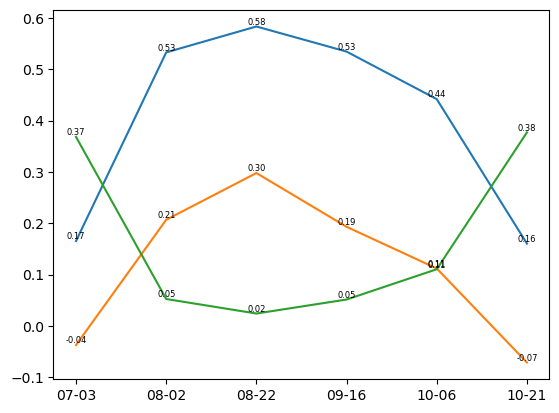

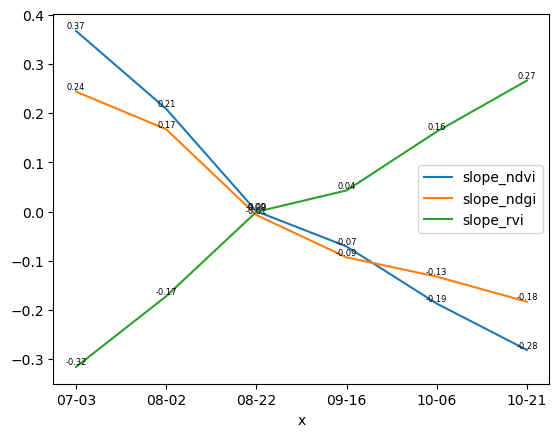

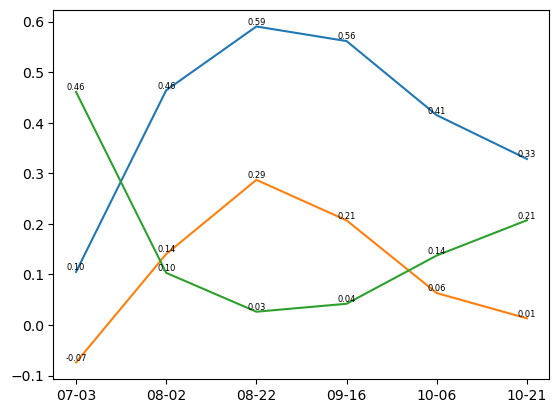

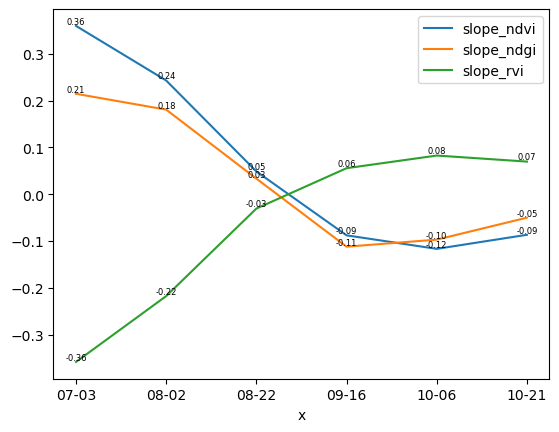

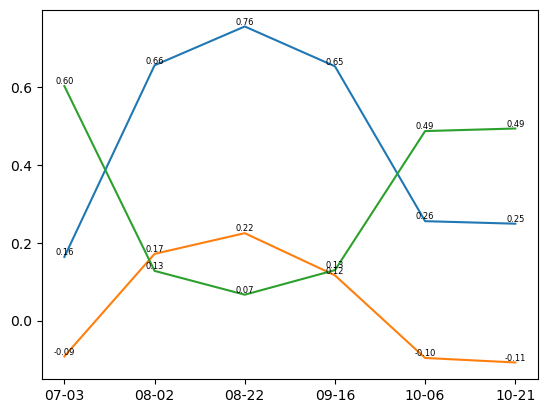

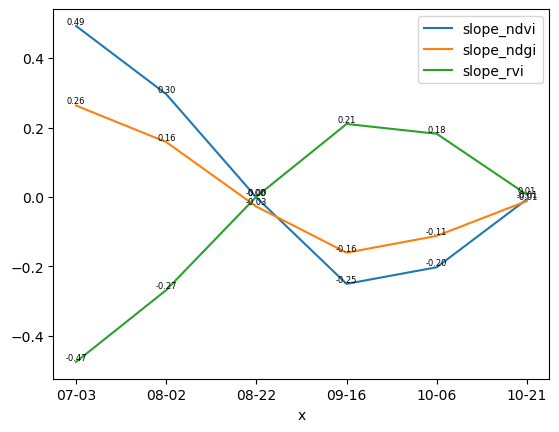

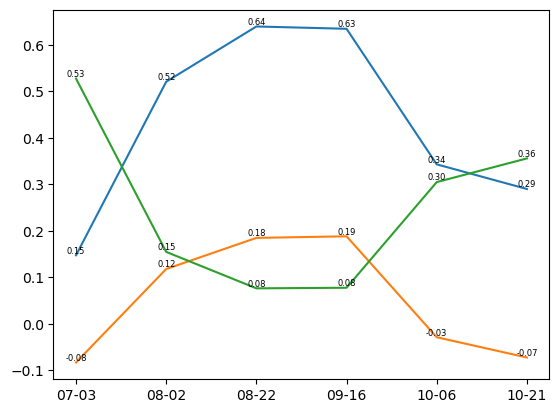

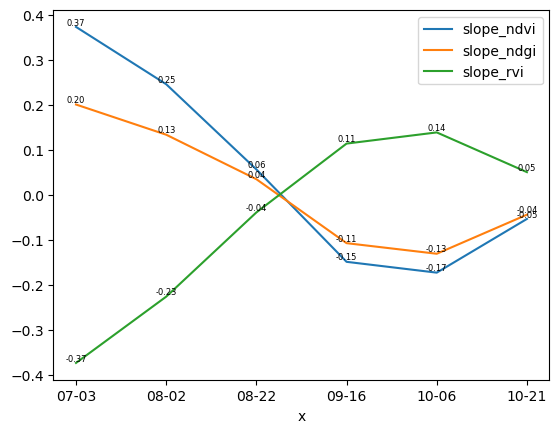

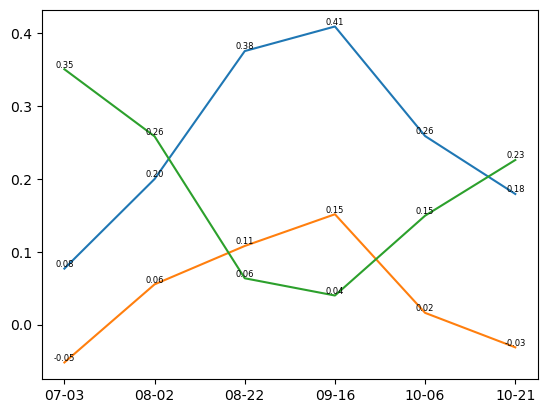

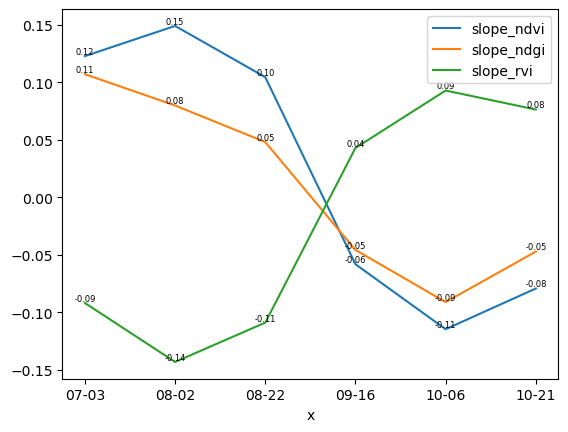

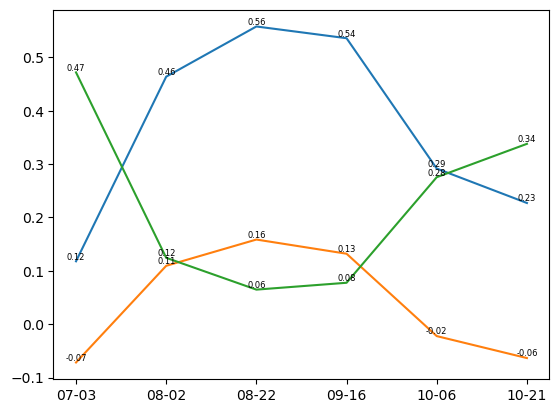

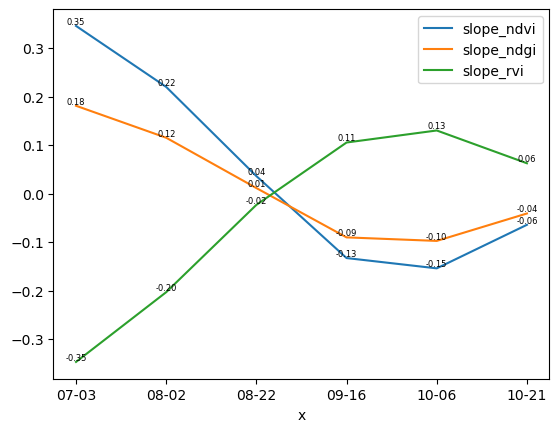

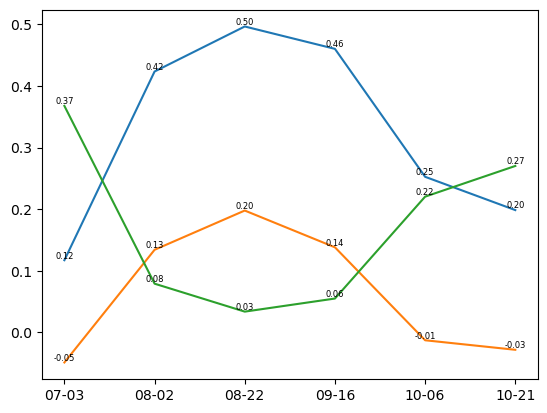

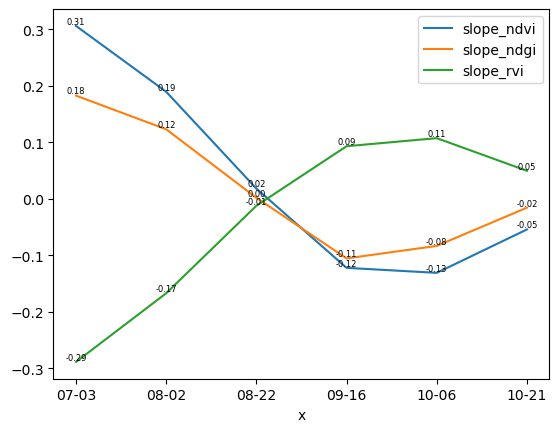

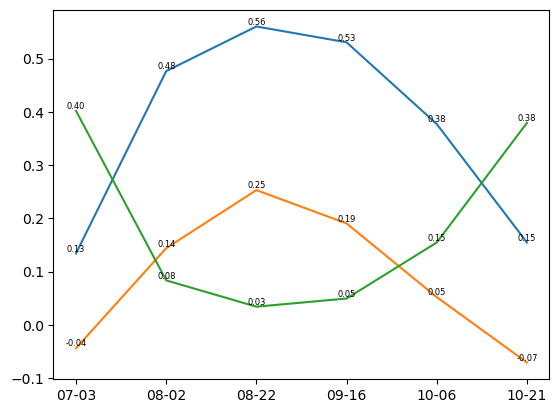

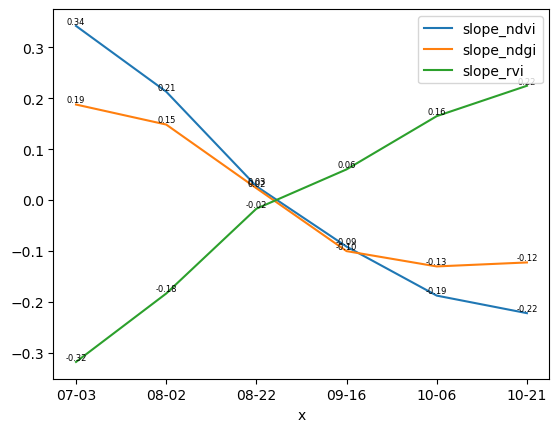

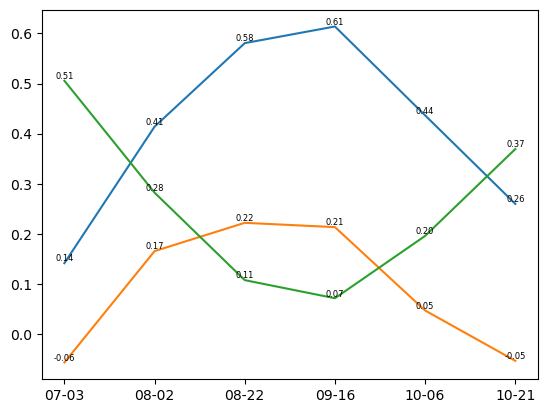

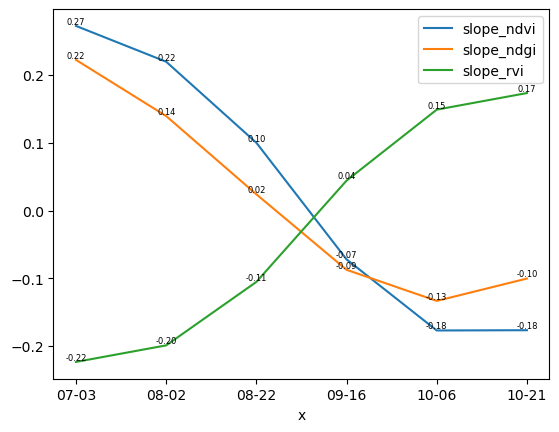

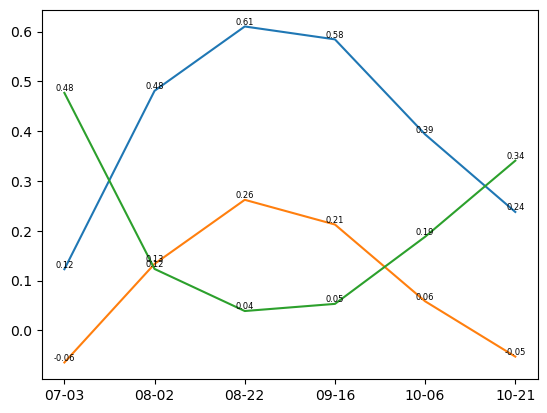

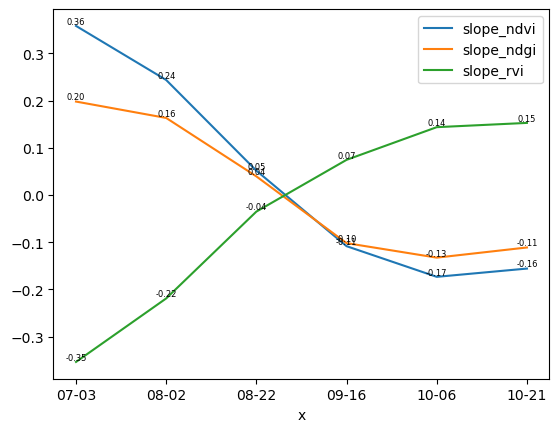

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

samplelist = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地')
for item in samplelist:
    samplefile = os.path.join(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地', item)
    df = pd.read_csv(os.path.join(samplefile, 'ndvi_ndgi_rvi.csv'), header=0, index_col=0)
    fig, ax = plt.subplots()
    ax.plot(df.T, label=item)
    # plt.legend()
    for m, n in zip(df.T.index, df.T['ndvi']):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=6)
    for m, n in zip(df.T.index, df.T['ndgi']):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=6)
    for m, n in zip(df.T.index, df.T['rvi']):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=6)
    plt.savefig(os.path.join(samplefile, '指数图_{}.png'.format(item)), dpi=600)

    x_data = [0, 1, 2, 3, 4, 5]
    slope_ndvi = np.gradient(df.T['ndvi'].values, x_data)
    slope_ndgi = np.gradient(df.T['ndgi'], x_data)
    slope_rvi = np.gradient(df.T['rvi'], x_data)
    vi = pd.DataFrame(slope_ndvi, columns={"slope_ndvi"})
    vi['slope_ndgi'] = slope_ndgi
    vi['slope_rvi'] = slope_rvi
    vi['x'] = ['07-03', '08-02', '08-22', '09-16', '10-06', '10-21']
    vi.plot(x='x', y=['slope_ndvi', 'slope_ndgi', 'slope_rvi'])
    for m, n in zip(vi.index, vi['slope_ndvi']):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=6)
    for m, n in zip(vi.index, vi['slope_ndgi']):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=6)
    for m, n in zip(vi.index, vi['slope_rvi']):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=6)
    plt.savefig(os.path.join(samplefile, '斜率图_{}.png'.format(item)), dpi=600)

# 合并样本数据值

In [37]:
samplelist = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地')

l_ndvi = []
l_ndgi = []
l_rvi = []
for i, item in enumerate(samplelist):
    samplefile = os.path.join(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地', item)
    df = pd.read_csv(os.path.join(samplefile, 'ndvi_ndgi_rvi.csv'), header=0, index_col=0)
    for n, row in df.iterrows():
        if n == "ndvi":
            l_ndvi.append(row.to_list())
        if n == "ndgi":
            l_ndgi.append(row.to_list())
        if n == "rvi":
            l_rvi.append(row.to_list())

ndvi_df = pd.DataFrame(l_ndvi, columns=df.columns)
ndgi_df = pd.DataFrame(l_ndgi, columns=df.columns)
rvi_df = pd.DataFrame(l_rvi, columns=df.columns)

In [39]:
ndvi_df.to_csv(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\NDVI_10.csv', index=False)
ndgi_df.to_csv(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\NDGI_10.csv', index=False)
rvi_df.to_csv(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\RVI_10.csv', index=False)

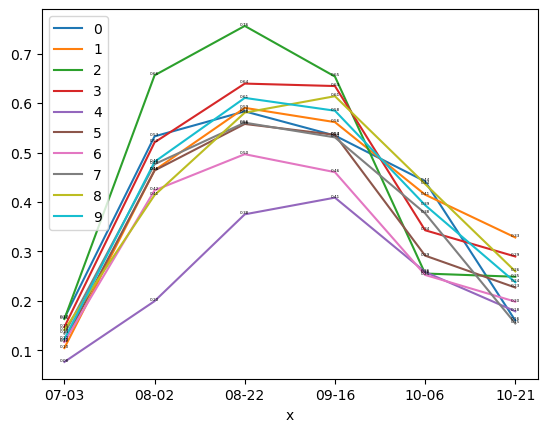

In [40]:
ndvi1=ndvi_df.T
ndvi1['x'] = ['07-03', '08-02', '08-22', '09-16', '10-06', '10-21']
ndvi1=ndvi1.rename(index={'07-03':0, '08-02':1, '08-22':2, '09-16':3, '10-06':4, '10-21':5})
ndvi1.plot(x='x')
for i in range(10):
    for m, n in zip(ndvi1.index, ndvi_df.iloc[i]):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=3)
plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\ndvi指数图.png', dpi=600)

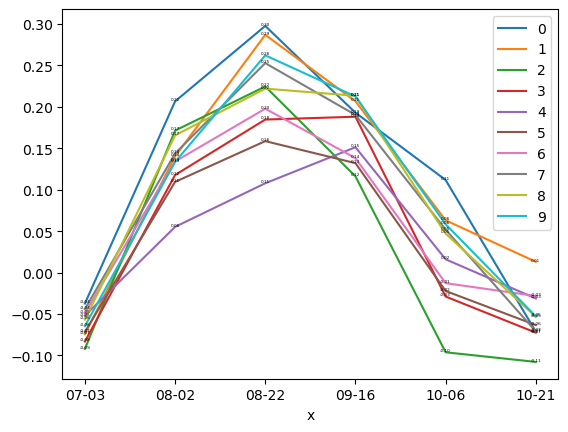

In [41]:
ndgi1=ndgi_df.T
ndgi1['x'] = ['07-03', '08-02', '08-22', '09-16', '10-06', '10-21']
ndgi1=ndgi1.rename(index={'07-03':0, '08-02':1, '08-22':2, '09-16':3, '10-06':4, '10-21':5})
ndgi1.plot(x='x')
for i in range(10):
    for m, n in zip(ndgi1.index, ndgi_df.iloc[i]):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=3)
plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\ndgi指数图.png', dpi=600)

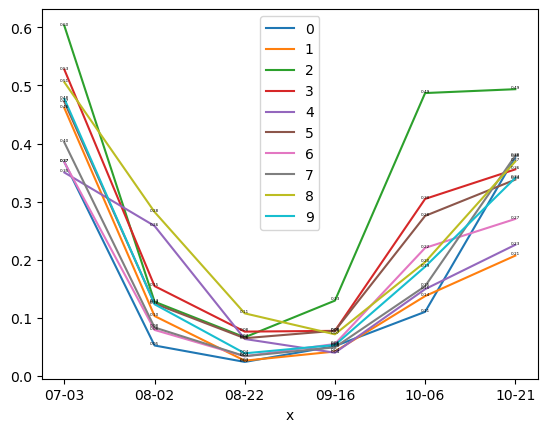

In [42]:
rvi1=rvi_df.T
rvi1['x'] = ['07-03', '08-02', '08-22', '09-16', '10-06', '10-21']
rvi1=rvi1.rename(index={'07-03':0, '08-02':1, '08-22':2, '09-16':3, '10-06':4, '10-21':5})
rvi1.plot(x='x')
for i in range(10):
    for m, n in zip(rvi1.index, rvi_df.iloc[i]):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=3)
plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\rvi指数图.png', dpi=600)

# 植被指数 斜率计算

In [43]:
df0 = ndvi_df.T
df0=df0.rename(index={'07-03':0, '08-02':1, '08-22':2, '09-16':3, '10-06':4, '10-21':5})
df0

,0,1,2,3,4,5,6,7,8,9
0,0.165220,0.104853,0.163462,0.147347,0.076788,0.117950,0.117222,0.134014,0.141576,0.122847
1,0.532689,0.464080,0.656014,0.520507,0.199660,0.463709,0.423501,0.476436,0.413910,0.481198
2,0.583173,0.590234,0.755829,0.639290,0.375072,0.557723,0.496603,0.560322,0.580584,0.610345
3,0.534268,0.561385,0.653498,0.634329,0.408796,0.535735,0.460276,0.530578,0.613808,0.584468
4,0.441626,0.414828,0.255430,0.342872,0.258521,0.291612,0.252606,0.377094,0.436437,0.393631
5,0.160332,0.328273,0.248929,0.289864,0.179118,0.227135,0.198576,0.154583,0.259842,0.237817


In [44]:
slope_ndvi = []
for item in df0:
    NDVI_data = df0[item].values
    slope_ndvi.append(np.gradient(NDVI_data, x_data))

In [45]:
df1 = ndgi_df.T
slope_ndgi = []
for item in df1:
    NDGI_data = df1[item].values
    slope_ndgi.append(np.gradient(NDGI_data, x_data))

In [46]:
df2 = rvi_df.T
slope_rvi = []
for item in df2:
    RVI_data = df2[item].values
    slope_rvi.append(np.gradient(RVI_data, x_data))

In [ ]:
slope_ndvi, slope_ndgi, slope_rvi

# slope_ndvi

In [ ]:
vi = pd.DataFrame(slope_ndvi)
ndvi = vi.T
# ndvi=ndvi.rename(index={0:'07-03', 1:'08-02', 2:'08-22', 3:'09-16', 4:'10-06', 5:'10-21'})
ndvi['x'] = ['07-03', '08-02', '08-22', '09-16', '10-06', '10-21']
ndvi

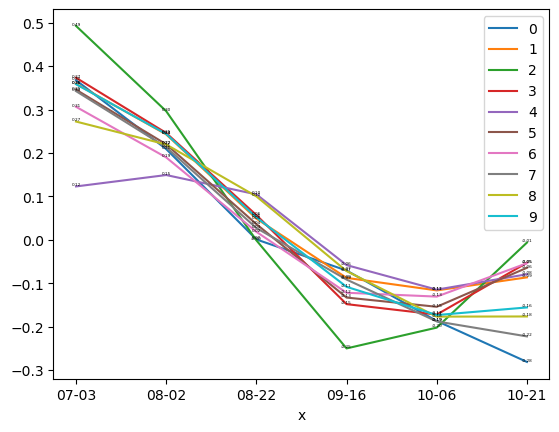

In [49]:
ndvi.plot(x='x')
for i in range(10):
    for m, n in zip(ndvi.index, vi.iloc[i]):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=3)
plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\ndvi斜率图.png', dpi=600)

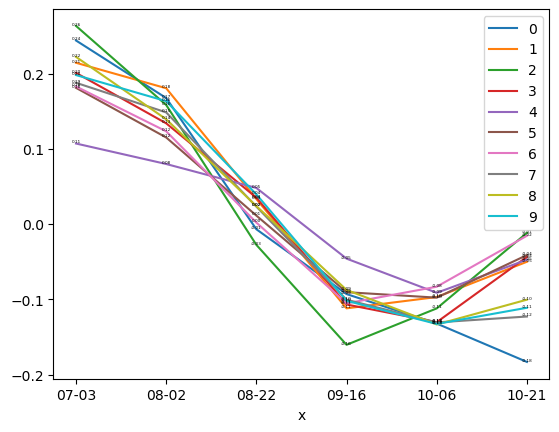

In [50]:
vi = pd.DataFrame(slope_ndgi)
ndgi = vi.T
ndgi['x'] = ['07-03', '08-02', '08-22', '09-16', '10-06', '10-21']
ndgi.plot(x='x')
for i in range(10):
    for m, n in zip(ndgi.index, vi.iloc[i]):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=3)
plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\ndgi斜率图.png', dpi=600)

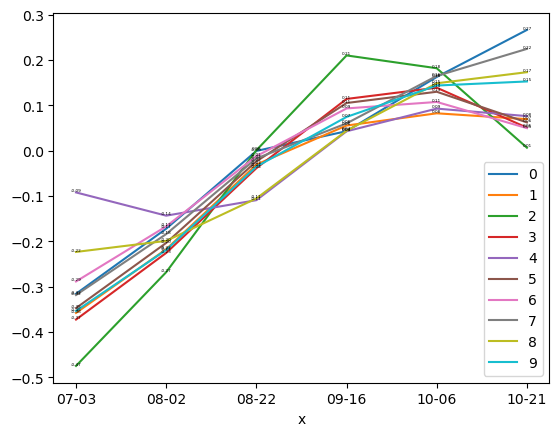

In [51]:
vi = pd.DataFrame(slope_rvi)
rvi = vi.T
rvi['x'] = ['07-03', '08-02', '08-22', '09-16', '10-06', '10-21']
rvi.plot(x='x')
for i in range(10):
    for m, n in zip(rvi.index, vi.iloc[i]):
        plt.text(m, n, '%.2f' % n, ha='center', va='bottom', fontsize=3)
plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\rvi斜率图.png', dpi=600)

In [52]:
import glob

In [68]:
path_png = glob.glob("E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\样本*\指数*.png")
path_png

['E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本0\\指数图_样本0.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本1\\指数图_样本1.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本2\\指数图_样本2.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本3\\指数图_样本3.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本4\\指数图_样本4.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本5\\指数图_样本5.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本6\\指数图_样本6.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本7\\指数图_样本7.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本8\\指数图_样本8.png',
 'E:\\Desktop\\Summary\\种植结构提取-水稻\\datas\\样本旱地\\样本9\\指数图_样本9.png']

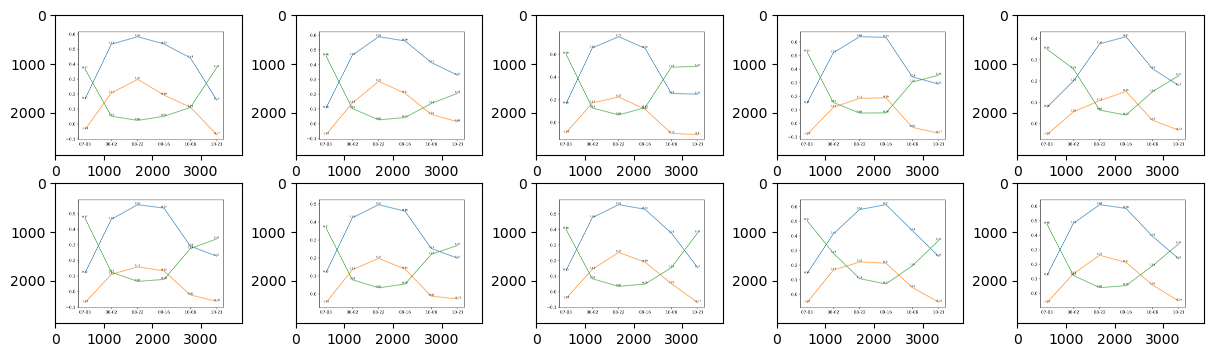

In [78]:
import matplotlib.image as mpimg
path_png = glob.glob("E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\样本*\指数*.png")
fig,axs = plt.subplots(2,5,figsize=(15,4))
axss = axs.flatten()
for ax,path in zip(axss,path_png):
    lena = mpimg.imread(path)
    ax.imshow(lena)

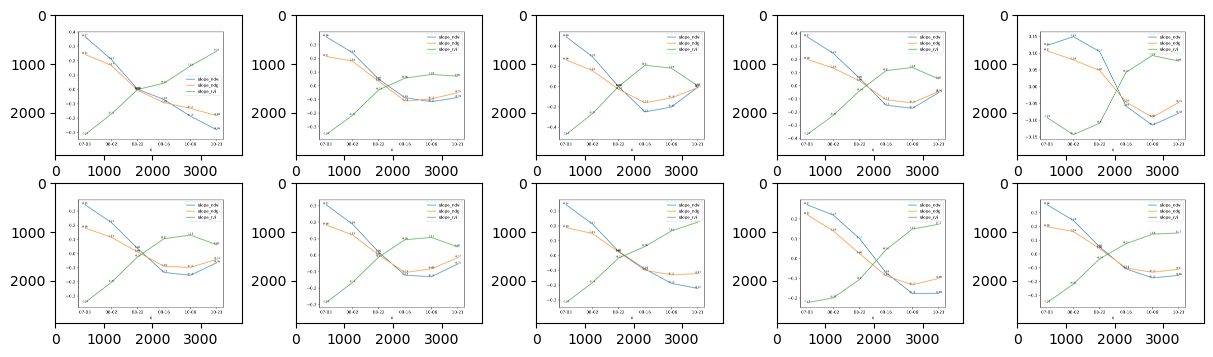

In [79]:
import matplotlib.image as mpimg
path_png = glob.glob("E:\Desktop\Summary\种植结构提取-水稻\datas\样本旱地\样本*\斜率*.png")
fig,axs = plt.subplots(2,5,figsize=(15,4))
axss = axs.flatten()
for ax,path in zip(axss,path_png):
    lena = mpimg.imread(path)
    ax.imshow(lena)

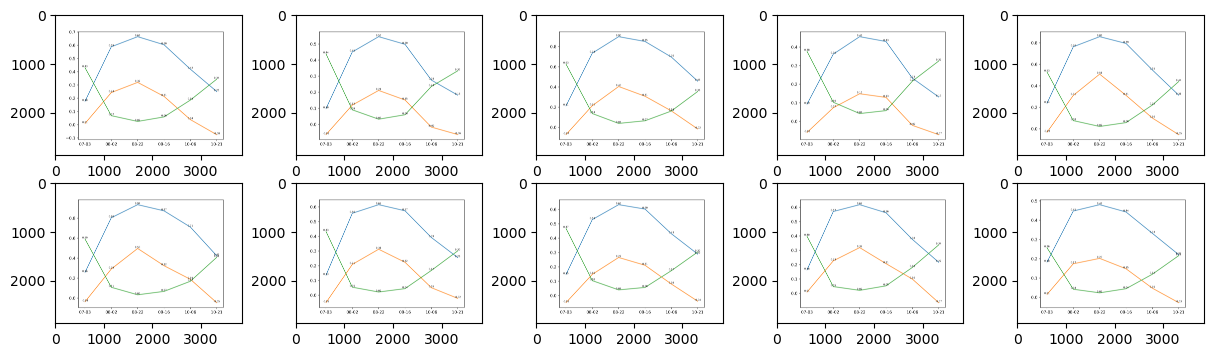

In [80]:
import matplotlib.image as mpimg
path_png = glob.glob("E:\Desktop\Summary\种植结构提取-水稻\datas\样本水田\样本*\指数*.png")
fig,axs = plt.subplots(2,5,figsize=(15,4))
axss = axs.flatten()
for ax,path in zip(axss,path_png):
    lena = mpimg.imread(path)
    ax.imshow(lena)

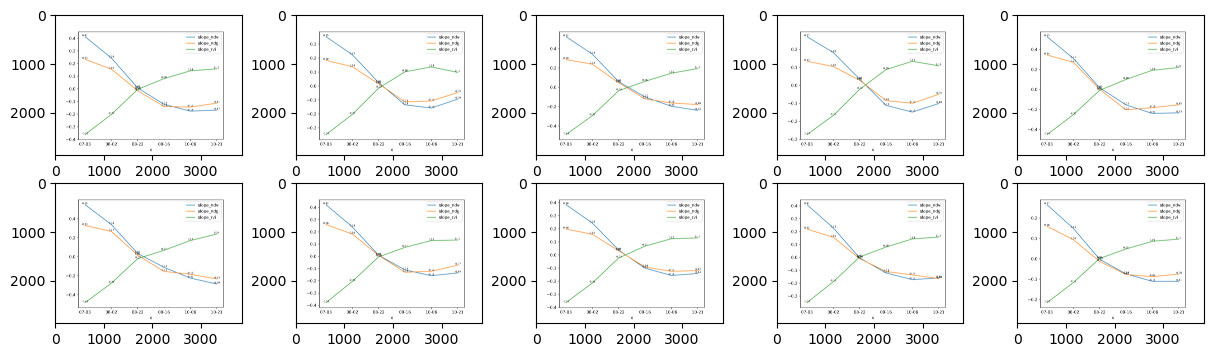

In [81]:
import matplotlib.image as mpimg
path_png = glob.glob("E:\Desktop\Summary\种植结构提取-水稻\datas\样本水田\样本*\斜率*.png")
fig,axs = plt.subplots(2,5,figsize=(15,4))
axss = axs.flatten()
for ax,path in zip(axss,path_png):
    lena = mpimg.imread(path)
    ax.imshow(lena)